In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 22 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score , recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import graphviz

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_not_imputed = pd.read_csv('/content/drive/MyDrive/dataset/2022_겨울_경진대회_dataset/total_credit.csv',index_col=0)
data_imputed = pd.read_csv('/content/drive/MyDrive/dataset/2022_겨울_경진대회_dataset/total_imputed.csv',index_col=0)
data_sampling_x = pd.read_csv('/content/drive/MyDrive/dataset/2022_겨울_경진대회_dataset/sampled_data_x.csv',index_col=0)
data_sampling_y = pd.read_csv('/content/drive/MyDrive/dataset/2022_겨울_경진대회_dataset/sampled_data_y.csv',index_col=0)

In [ ]:
le = LabelEncoder()

data_not_imputed['NAME_CONTRACT_TYPE'] = le.fit_transform(data_not_imputed['NAME_CONTRACT_TYPE'])
data_not_imputed['CODE_GENDER'] = le.fit_transform(data_not_imputed['CODE_GENDER'])
data_not_imputed['new_REGION'] = le.fit_transform(data_not_imputed['new_REGION'])
data_not_imputed['new_HOME_TYPE'] = le.fit_transform(data_not_imputed['new_HOME_TYPE'])
data_not_imputed['new_EDU_LEVEL'] = le.fit_transform(data_not_imputed['new_EDU_LEVEL'])
data_imputed['NAME_CONTRACT_TYPE'] = le.fit_transform(data_imputed['NAME_CONTRACT_TYPE'])
data_imputed['CODE_GENDER'] = le.fit_transform(data_imputed['CODE_GENDER'])

In [ ]:
# scaler = MinMaxScaler()

# data_imputed = pd.DataFrame(scaler.fit_transform(data_imputed), columns = data_imputed.columns)
# data_sampling_x = pd.DataFrame(scaler.fit_transform(data_sampling_x), columns = data_sampling_x.columns)
# data_sampling_y = pd.DataFrame(scaler.fit_transform(data_sampling_y), columns = data_sampling_y.columns)

In [ ]:
data_sampling = pd.concat([data_sampling_x, data_sampling_y], axis=1)

# 함수

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%") 
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"F1-score: {f1_score(y_train, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"F1-score: {f1_score(y_test, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

# LGBM (결측치 포함)

In [ ]:
X = data_not_imputed.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data_not_imputed[['TARGET']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=True)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

In [ ]:
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 92.09%
Precision Score: 90.67%
Recall Score: 92.09%
F1-score: 88.56%
_______________________________________________
Confusion Matrix: 
 [[197780    159]
 [ 16867    450]]

Test Result:
Accuracy Score: 91.89%
Precision Score: 88.98%
Recall Score: 91.89%
F1-score: 88.24%
_______________________________________________
Confusion Matrix: 
 [[84640   105]
 [ 7379   129]]



# LGBM (결측치 처리후)

In [ ]:
data_imputed

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,DAYS_BIRTH,DAYS_REGISTRATION,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,new_CREDIT_INCOME,...,previous_APPLICATION_TO_CREDIT,previous_REFUSED_COUNT,previous_DAY_DECISION,EXT_SOURCE_2,EXT_SOURCE_3,new_EMPLOYED_DAYS,new_GOODS_INCOME,previous_AMT_GOODS_PRICE,new_ANNUITY_INCOME,previous_AMT_ANNUITY
0,100002,1,0,1,-9461,-3648.0,2,10,0.083037,2.007889,...,0.000,0.0,606.000000,0.262949,0.139376,-637.000000,1.733333,179055.000,0.121978,9251.775000
1,100003,0,0,0,-16765,-1186.0,1,11,0.311267,4.790750,...,48754.500,0.0,1305.000000,0.622246,0.533930,-1188.000000,4.183333,435436.500,0.132217,56553.990000
2,100004,0,1,1,-19046,-4260.0,2,9,0.529160,2.000000,...,-4176.000,0.0,815.000000,0.555912,0.729567,-225.000000,2.000000,24282.000,0.100000,5357.250000
3,100006,0,0,0,-19005,-9833.0,2,17,0.554386,2.316167,...,19492.240,1.0,272.444444,0.650442,0.507937,-3039.000000,2.200000,408304.890,0.219900,23651.175000
4,100007,0,0,1,-19932,-4311.0,2,11,0.502067,4.222222,...,16108.500,0.0,1222.833333,0.322738,0.537932,-3038.000000,4.222222,150530.250,0.179963,12278.805000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307504,456251,0,0,1,-9327,-8456.0,1,15,0.145570,1.617143,...,0.000,0.0,273.000000,0.681632,0.435123,-236.000000,1.428571,40455.000,0.174971,6605.910000
307505,456252,0,0,0,-20775,-4388.0,2,8,0.558918,3.743750,...,-774.000,0.0,2497.000000,0.115992,0.578849,-3364.229609,3.125000,57595.500,0.166687,10074.465000
307506,456253,0,0,0,-14966,-6737.0,3,9,0.744026,4.429176,...,-3537.000,0.0,2380.000000,0.535722,0.218859,-7921.000000,3.823529,24162.750,0.195941,4770.405000
307507,456254,1,0,0,-11961,-2562.0,2,9,0.428713,2.164368,...,13122.000,0.0,299.500000,0.514163,0.661024,-4786.000000,1.868421,121317.750,0.118158,10681.132500


In [ ]:
X = data_imputed.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data_imputed[['TARGET']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

In [ ]:
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 92.93%
Precision Score: 92.41%
Recall Score: 92.93%
F1-score: 90.56%
_______________________________________________
Confusion Matrix: 
 [[197496    443]
 [ 14771   2546]]

Test Result:
Accuracy Score: 92.60%
Precision Score: 91.59%
Recall Score: 92.60%
F1-score: 90.07%
_______________________________________________
Confusion Matrix: 
 [[84474   271]
 [ 6553   955]]



In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False)

scores = cross_val_score(lgb_clf, X, y, scoring='precision', cv=3)
print('교차 검증별 성능:', np.round(scores,4))
print('평균 검증 성능:', np.round(np.mean(scores)))

교차 검증별 성능: [0.8085 0.8014 0.7977]
평균 검증 성능: 1.0


# LGBM (샘플링 후)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_sampling_x, data_sampling_y, test_size=0.3, random_state=42)

In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

In [ ]:
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 92.93%
Precision Score: 93.22%
Recall Score: 92.93%
F1-score: 92.92%
_______________________________________________
Confusion Matrix: 
 [[190101   5889]
 [ 21776 173797]]

Test Result:
Accuracy Score: 92.72%
Precision Score: 93.04%
Recall Score: 92.72%
F1-score: 92.71%
_______________________________________________
Confusion Matrix: 
 [[81192  2506]
 [ 9712 74403]]



In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False)

scores = cross_val_score(lgb_clf, data_sampling_x, data_sampling_y, scoring='precision', cv=3)
print('교차 검증별 성능:', np.round(scores,4))
print('평균 검증 성능:', np.round(np.mean(scores)))

교차 검증별 성능: [0.9757 0.9579 0.9596]
평균 검증 성능: 1.0


# RandomForest (결측치 처리후)

In [ ]:
X = data_imputed.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data_imputed[['TARGET']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
F1-score: 100.00%
_______________________________________________
Confusion Matrix: 
 [[197939      0]
 [     8  17309]]

Test Result:
Accuracy Score: 92.15%
Precision Score: 91.27%
Recall Score: 92.15%
F1-score: 88.81%
_______________________________________________
Confusion Matrix: 
 [[84661    84]
 [ 7157   351]]



In [ ]:
rfc = RandomForestClassifier(random_state=42)

scores = cross_val_score(rfc, X, y, scoring='precision', cv=3)
print('교차 검증별 성능:', np.round(scores,4))
print('평균 검증 성능:', np.round(np.mean(scores)))

교차 검증별 성능: [0.8362 0.7917 0.8155]
평균 검증 성능: 1.0


# RandomForest (샘플링 후)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_sampling_x, data_sampling_y, test_size=0.3, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
F1-score: 100.00%
_______________________________________________
Confusion Matrix: 
 [[195989      1]
 [     0 195573]]

Test Result:
Accuracy Score: 93.29%
Precision Score: 93.40%
Recall Score: 93.29%
F1-score: 93.29%
_______________________________________________
Confusion Matrix: 
 [[80148  3550]
 [ 7707 76408]]



In [ ]:
rfc = RandomForestClassifier(random_state=42)

scores = cross_val_score(rfc, data_sampling_x, data_sampling_y, scoring='precision', cv=3)
print('교차 검증별 성능:', np.round(scores,4))
print('평균 검증 성능:', np.round(np.mean(scores)))

교차 검증별 성능: [0.9587 0.9466 0.9484]
평균 검증 성능: 1.0


# Catboost (결측치 처리후)

In [ ]:
X = data_imputed.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data_imputed[['TARGET']]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307509 entries, 0 to 307508
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   NAME_CONTRACT_TYPE              307509 non-null  int64  
 1   CODE_GENDER                     307509 non-null  int64  
 2   DAYS_BIRTH                      307509 non-null  int64  
 3   DAYS_REGISTRATION               307509 non-null  float64
 4   REGION_RATING_CLIENT_W_CITY     307509 non-null  int64  
 5   HOUR_APPR_PROCESS_START         307509 non-null  int64  
 6   EXT_SOURCE_1                    307509 non-null  float64
 7   new_CREDIT_INCOME               307509 non-null  float64
 8   new_REGION                      307509 non-null  int64  
 9   new_REQ_CREDIT                  307509 non-null  int64  
 10  new_HOME_TYPE                   307509 non-null  int64  
 11  new_EDU_LEVEL                   307509 non-null  int64  
 12  new_ECONOMIC_POP

In [ ]:
cat_x = X.copy()
cat_y = y.copy()
cat_x[['NAME_CONTRACT_TYPE','CODE_GENDER','new_REGION','new_HOME_TYPE','new_EDU_LEVEL']] = cat_x[['NAME_CONTRACT_TYPE','CODE_GENDER','new_REGION','new_HOME_TYPE','new_EDU_LEVEL']].astype('object')

In [ ]:
cat_cols = cat_x.columns[cat_x.dtypes == 'object'].to_list()

In [ ]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'new_REGION',
 'new_HOME_TYPE',
 'new_EDU_LEVEL']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cat_x, cat_y, test_size=0.3, random_state=42)

In [ ]:
train_pool = Pool(X_train,y_train, cat_features=cat_cols)
eval_pool = Pool(X_test, y_test, cat_features=cat_cols)

In [ ]:
params = {'iterations':200,
          'random_seed':42,
          'learning_rate':0.02,
          'loss_function':'Logloss', 
          'custom_metric':['Logloss','AUC','Precision'],
          'early_stopping_rounds':20,
          'use_best_model': True,
          'bagging_temperature':1,
          'verbose':False}

In [ ]:
clf_catboost = CatBoostClassifier(**params)
clf_catboost.fit(train_pool, eval_set=eval_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print_score(clf_catboost, X_train, y_train, X_test, y_test, train=True)
print_score(clf_catboost, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 91.99%
Precision Score: 90.81%
Recall Score: 91.99%
F1-score: 88.22%
_______________________________________________
Confusion Matrix: 
 [[197906     33]
 [ 17205    112]]

Test Result:
Accuracy Score: 91.89%
Precision Score: 90.25%
Recall Score: 91.89%
F1-score: 88.06%
_______________________________________________
Confusion Matrix: 
 [[84730    15]
 [ 7470    38]]



In [ ]:
clf_catboost.best_score_

{'learn': {'Logloss': 0.2306391586390096, 'Precision': 1.0},
 'validation': {'Logloss': 0.23472317756795416,
  'Precision': 1.0,
  'AUC': 0.804576885251637}}

# Catboost (샘플링 후)

In [ ]:
cat_x = data_sampling_x
cat_y = data_sampling_y
cat_x[['NAME_CONTRACT_TYPE','CODE_GENDER','new_REGION','new_HOME_TYPE','new_EDU_LEVEL']] = cat_x[['NAME_CONTRACT_TYPE','CODE_GENDER','new_REGION','new_HOME_TYPE','new_EDU_LEVEL']].astype('object')

In [ ]:
cat_cols = cat_x.columns[cat_x.dtypes == 'object'].to_list()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cat_x, cat_y, test_size=0.3, random_state=42)

In [ ]:
train_pool = Pool(X_train,y_train, cat_features=cat_cols)
eval_pool = Pool(X_test, y_test, cat_features=cat_cols)

In [ ]:
params = {'iterations':200,
          'random_seed':42,
          'learning_rate':0.02,
          'loss_function':'Logloss', 
          'custom_metric':['Logloss','AUC','Precision'],
          'early_stopping_rounds':20,
          'use_best_model': True,
          'bagging_temperature':1,
          'verbose':False}

In [ ]:
clf_catboost = CatBoostClassifier(**params)
clf_catboost.fit(train_pool, eval_set=eval_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print_score(clf_catboost, X_train, y_train, X_test, y_test, train=True)
print_score(clf_catboost, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 89.73%
Precision Score: 90.09%
Recall Score: 89.73%
F1-score: 89.71%
_______________________________________________
Confusion Matrix: 
 [[185236  10754]
 [ 29461 166112]]

Test Result:
Accuracy Score: 89.60%
Precision Score: 90.00%
Recall Score: 89.60%
F1-score: 89.57%
_______________________________________________
Confusion Matrix: 
 [[79168  4530]
 [12924 71191]]



# RandomForest Hyperparameter

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_sampling_x, data_sampling_y, test_size=0.3, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
F1-score: 100.00%
_______________________________________________
Confusion Matrix: 
 [[195989      1]
 [     0 195573]]

Test Result:
Accuracy Score: 93.29%
Precision Score: 93.40%
Recall Score: 93.29%
F1-score: 93.29%
_______________________________________________
Confusion Matrix: 
 [[80148  3550]
 [ 7707 76408]]



In [ ]:
params ={
    'n_estimators':[100],
    'max_depth':[6,8,10],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

In [ ]:
grid_cv = GridSearchCV(rfc, param_grid=params, cv=2, n_jobs=-1)

In [ ]:
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [100]})

In [ ]:
print(f"Best Param: {grid_cv.best_params_}")
max_depth = grid_cv.best_params_['max_depth']
min_samples_leaf = grid_cv.best_params_['min_samples_leaf']
min_samples_split = grid_cv.best_params_['min_samples_split']
n_estimators = grid_cv.best_params_['n_estimators']

# default 값 = max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100

Best Param: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [ ]:
rfc = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
F1-score: 100.00%
_______________________________________________
Confusion Matrix: 
 [[195989      1]
 [     0 195573]]

Test Result:
Accuracy Score: 93.29%
Precision Score: 93.40%
Recall Score: 93.29%
F1-score: 93.29%
_______________________________________________
Confusion Matrix: 
 [[80148  3550]
 [ 7707 76408]]



In [ ]:
rfc = RandomForestClassifier(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                       random_state=42)

In [ ]:
print_score(rfc, X_train, y_train, X_test, y_test, train=True)
print_score(rfc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 86.06%
Precision Score: 86.06%
Recall Score: 86.06%
F1-score: 86.06%
_______________________________________________
Confusion Matrix: 
 [[168993  26997]
 [ 27586 167987]]

Test Result:
Accuracy Score: 85.72%
Precision Score: 85.72%
Recall Score: 85.72%
F1-score: 85.72%
_______________________________________________
Confusion Matrix: 
 [[72067 11631]
 [12329 71786]]



# LGBM Hyperparameter

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_sampling_x, data_sampling_y, test_size=0.3, random_state=42)

In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

In [ ]:
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=False)

In [ ]:
params ={
    'n_estimators':[50, 100, 150],
    'max_depth':[-1, 8, 10, 12],
    'min_samples_leaf':[8,12,16,20],
    'num_leaves':[31, 62, 93, 124]
}

In [ ]:
grid_cv = GridSearchCV(lgb_clf, param_grid=params, cv=2, n_jobs=-1)

In [ ]:
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=2,
             estimator=LGBMClassifier(max_depth=10, min_samples_leaf=8,
                                      min_samples_split=8, num_leaves=90,
                                      random_state=42, use_missing=False),
             n_jobs=-1,
             param_grid={'max_depth': [-1, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 16, 20],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [31, 62, 93, 124]})

In [ ]:
print(f"Best Param: {grid_cv.best_params_}")
max_depth = grid_cv.best_params_['max_depth']
min_samples_leaf = grid_cv.best_params_['min_samples_leaf']
num_leaves = grid_cv.best_params_['num_leaves']
n_estimators = grid_cv.best_params_['n_estimators']

Best Param: {'max_depth': -1, 'min_samples_leaf': 8, 'n_estimators': 150, 'num_leaves': 124}


In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state=42, use_missing=False, max_depth=-1, min_samples_leaf=8, n_estimators=150, num_leaves=124)
lgb_clf.fit(X_train, y_train)

LGBMClassifier(min_samples_leaf=8, n_estimators=150, num_leaves=124,
               random_state=42, use_missing=False)

In [ ]:
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 95.19%
Precision Score: 95.36%
Recall Score: 95.19%
F1-score: 95.19%
_______________________________________________
Confusion Matrix: 
 [[192600   3390]
 [ 15441 180132]]

Test Result:
Accuracy Score: 94.29%
Precision Score: 94.50%
Recall Score: 94.29%
F1-score: 94.29%
_______________________________________________
Confusion Matrix: 
 [[81755  1943]
 [ 7637 76478]]



In [ ]:
scores = cross_val_score(lgb_clf, data_sampling_x, data_sampling_y, scoring='precision', cv=3)
print('교차 검증별 성능:', np.round(scores,4))
print('평균 검증 성능:', np.round(np.mean(scores)))

교차 검증별 성능: [0.9835 0.9673 0.9671]
평균 검증 성능: 1.0


<function matplotlib.pyplot.show(*args, **kw)>

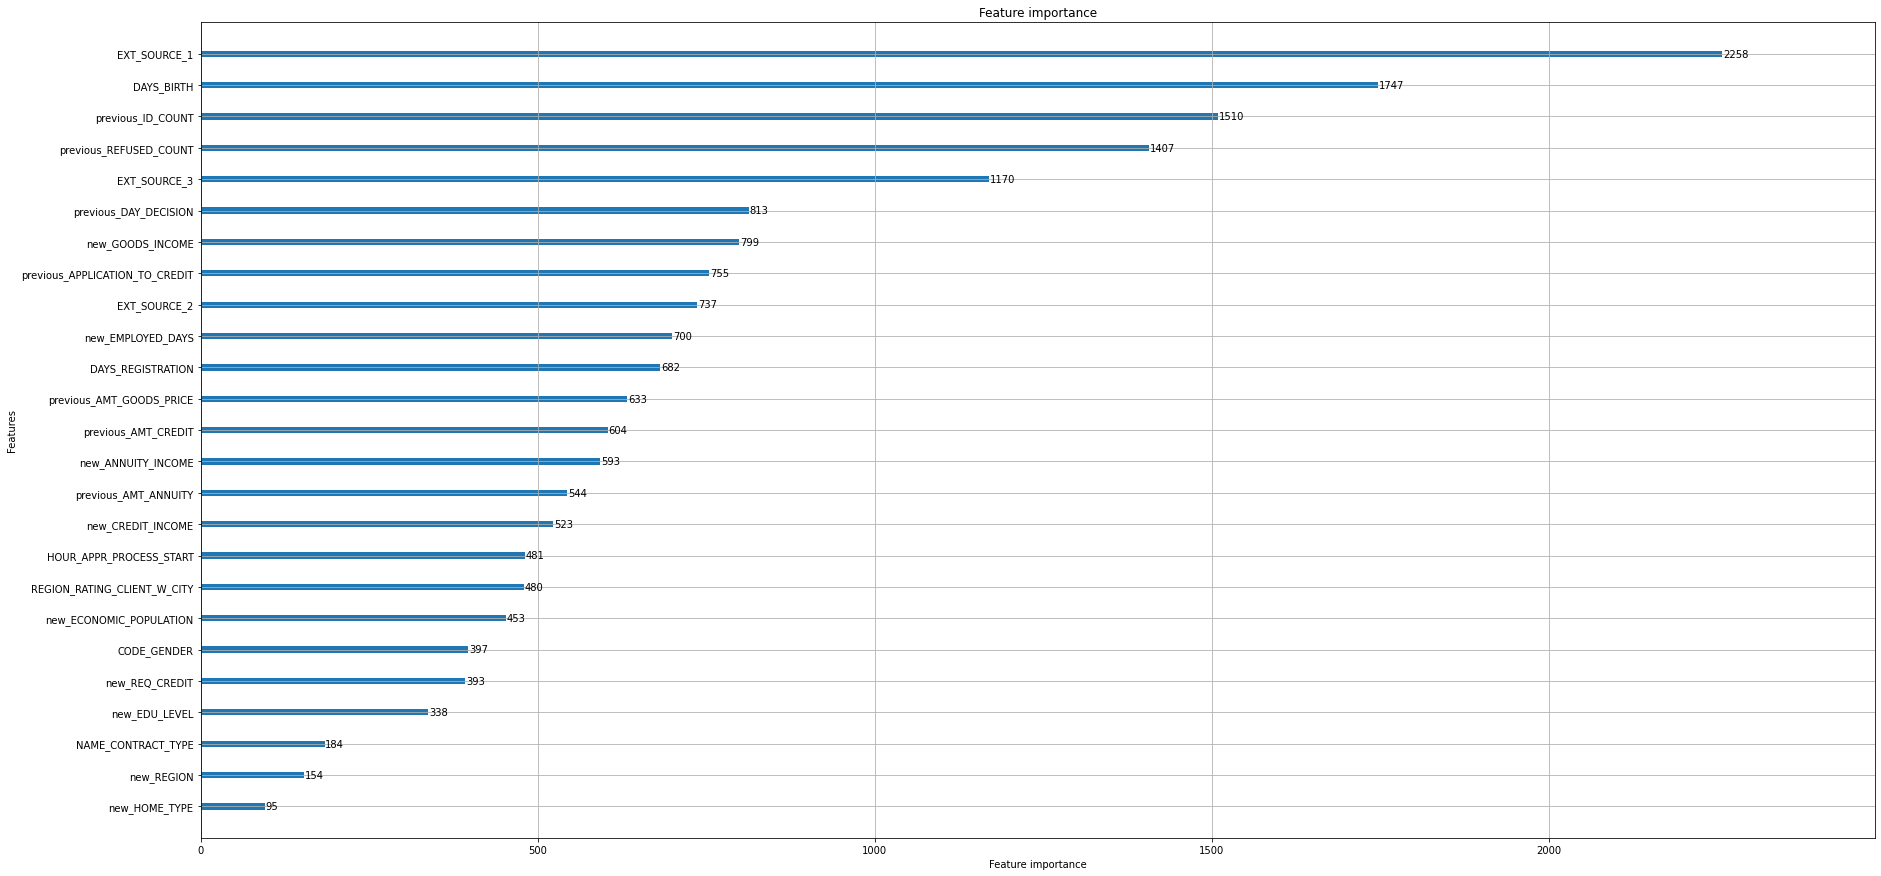

In [ ]:
f, ax = plt.subplots(figsize=(30,15))
plot_importance(lgb_clf, ax=ax)
plt.show

In [ ]:
lgb.plot_tree(lgb_clf, figsize=(30, 15), show_info=['split_gain'])
plt.show()

In [ ]:
lgb.create_tree_digraph(lgb_clf)

# 결과확인

## 실제값 1, 예측값 0 시각화

In [ ]:
predict_value = lgb_clf.predict(X_test)

In [ ]:
actual_value = y_test.copy()

In [ ]:
reason_dataset = X_test.copy()

In [ ]:
actual_value.reset_index(drop=False, inplace=True)

In [ ]:
reason_dataset.reset_index(drop=True, inplace=True)

In [ ]:
actual_value['predict_value'] = pd.DataFrame(predict_value)

In [ ]:
analysis_data = pd.concat([actual_value, reason_dataset], axis=1)

In [ ]:
analysis_data = analysis_data[analysis_data['TARGET'] == 1]

In [ ]:
analysis_data = analysis_data[analysis_data['predict_value'] == 0]

In [ ]:
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7637 entries, 3 to 167812
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           7637 non-null   int64  
 1   TARGET                          7637 non-null   int64  
 2   predict_value                   7637 non-null   int64  
 3   NAME_CONTRACT_TYPE              7637 non-null   int64  
 4   CODE_GENDER                     7637 non-null   int64  
 5   DAYS_BIRTH                      7637 non-null   int64  
 6   DAYS_REGISTRATION               7637 non-null   float64
 7   REGION_RATING_CLIENT_W_CITY     7637 non-null   int64  
 8   HOUR_APPR_PROCESS_START         7637 non-null   int64  
 9   EXT_SOURCE_1                    7637 non-null   float64
 10  new_CREDIT_INCOME               7637 non-null   float64
 11  new_REGION                      7637 non-null   int64  
 12  new_REQ_CREDIT                  

<function matplotlib.pyplot.show(*args, **kw)>

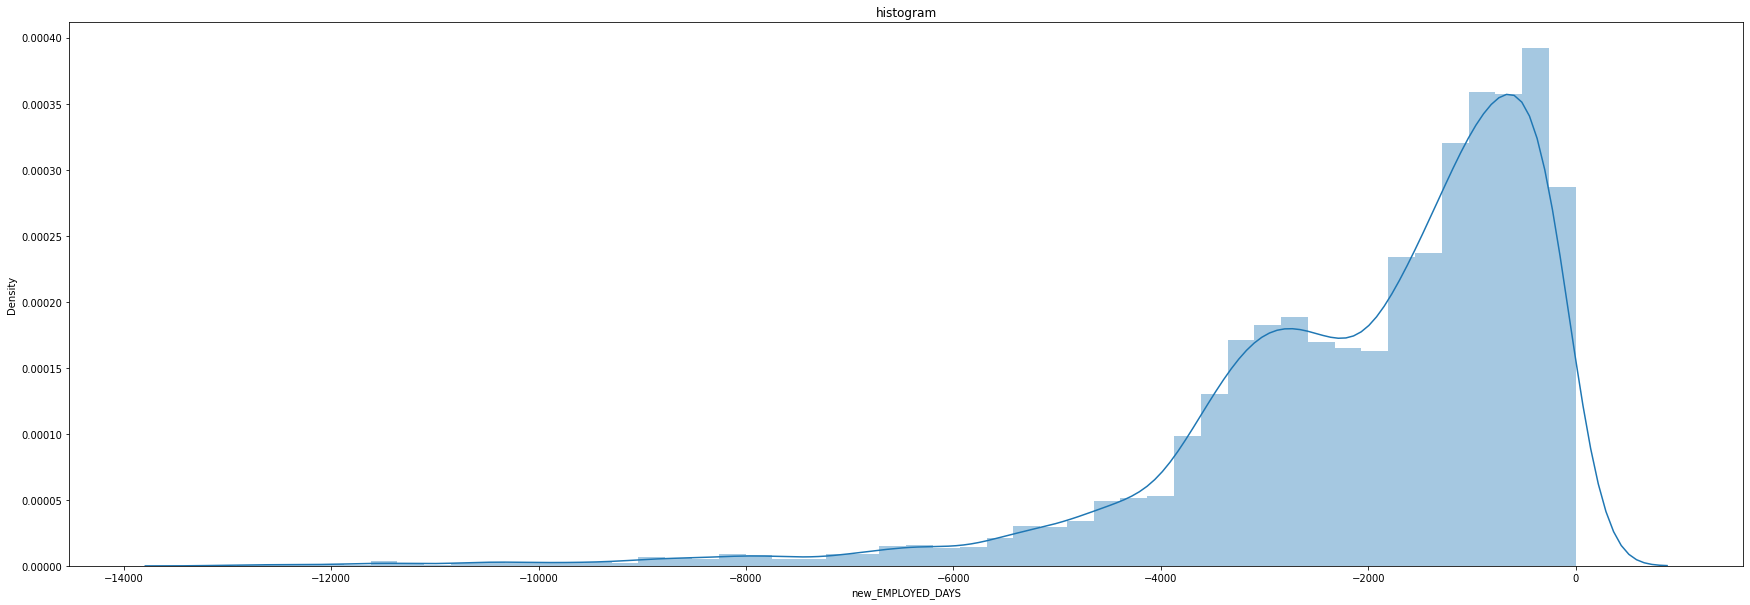

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['new_EMPLOYED_DAYS'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

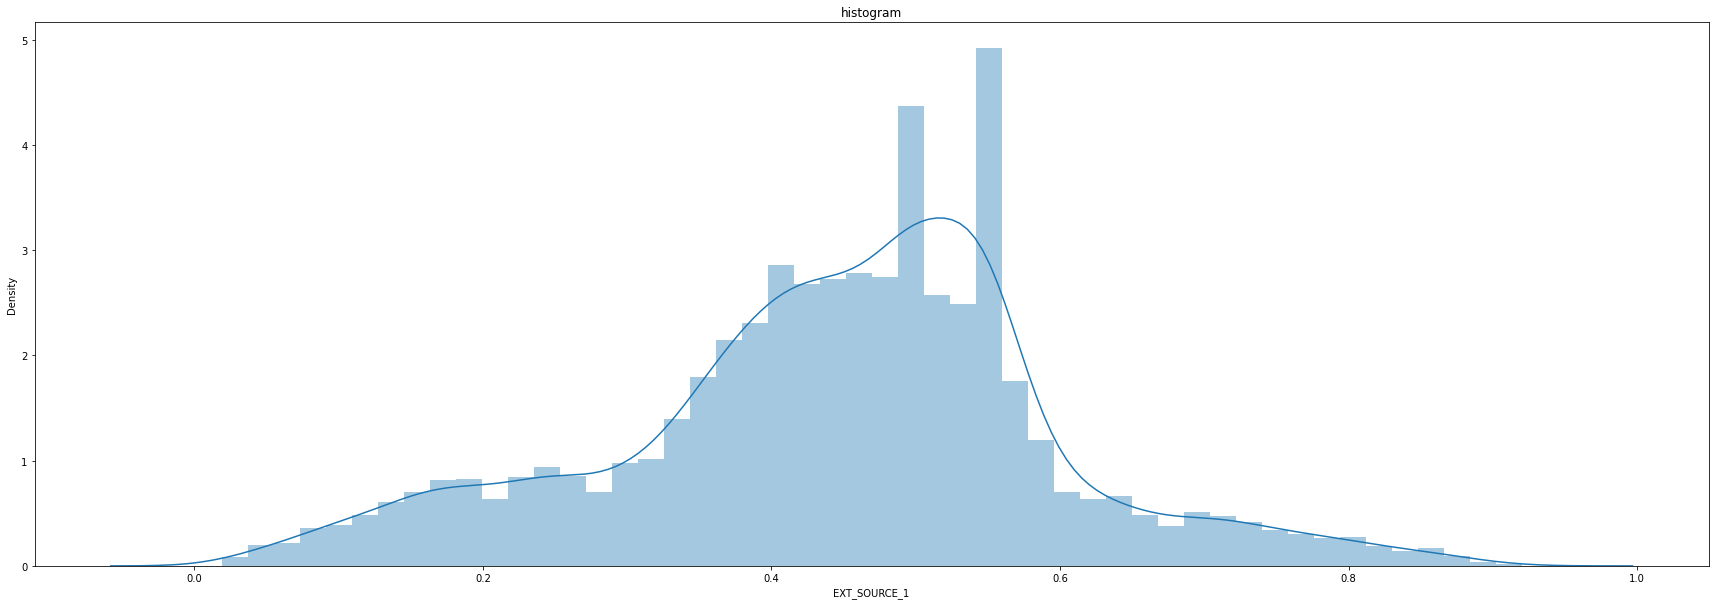

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['EXT_SOURCE_1'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

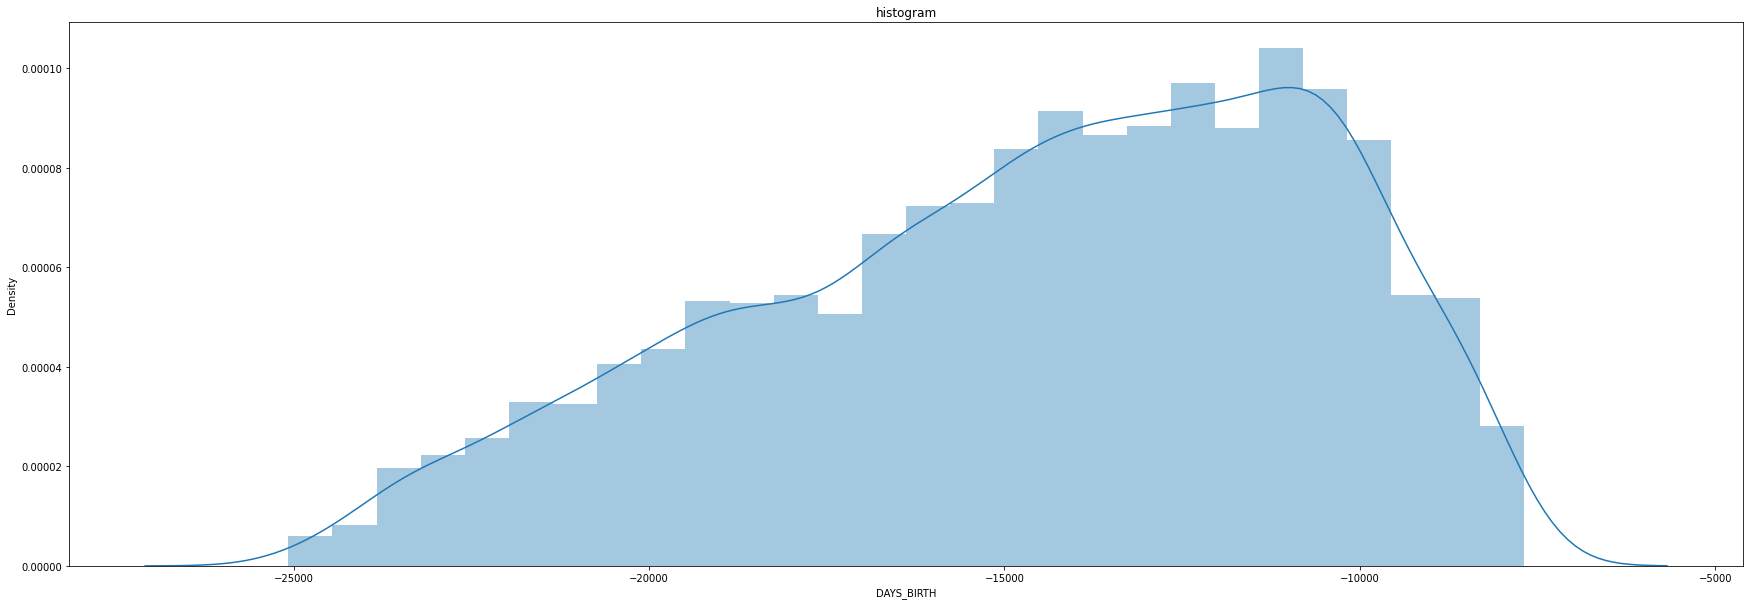

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['DAYS_BIRTH'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

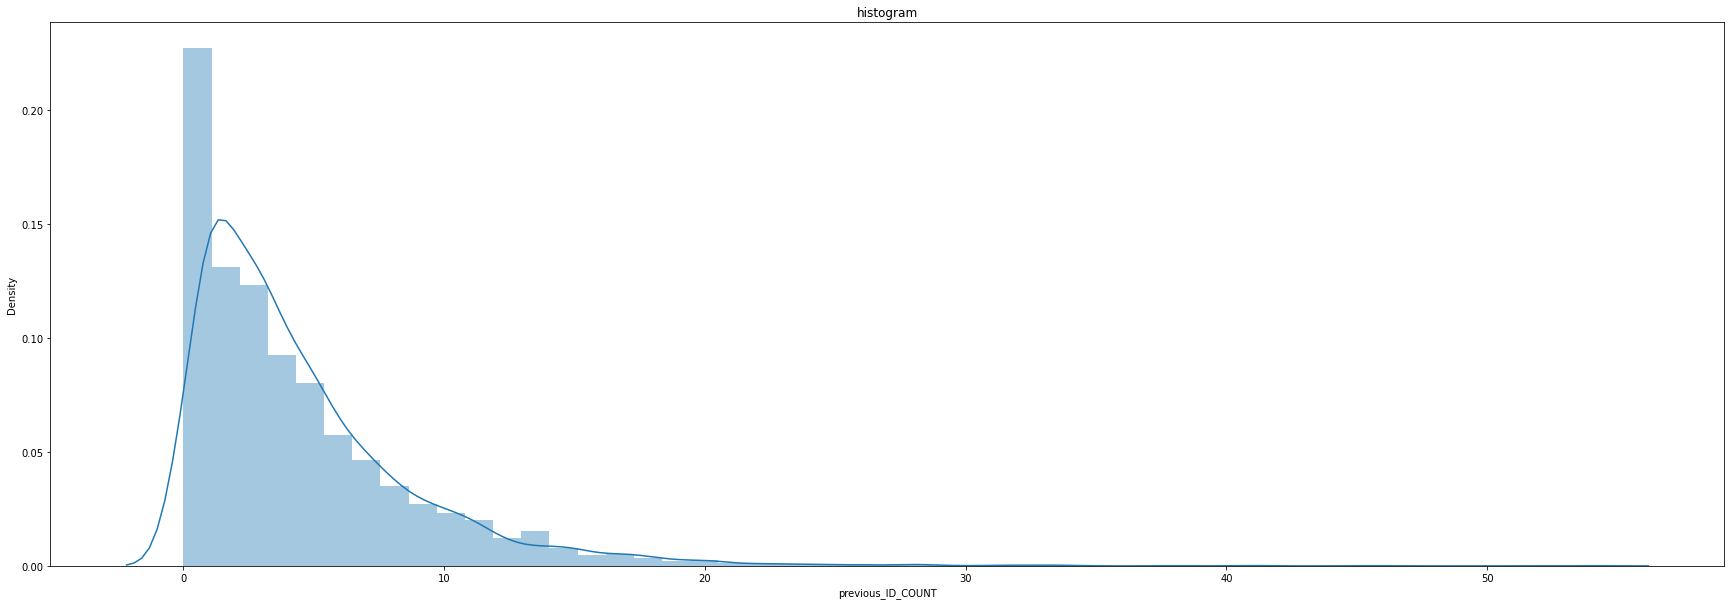

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['previous_ID_COUNT'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

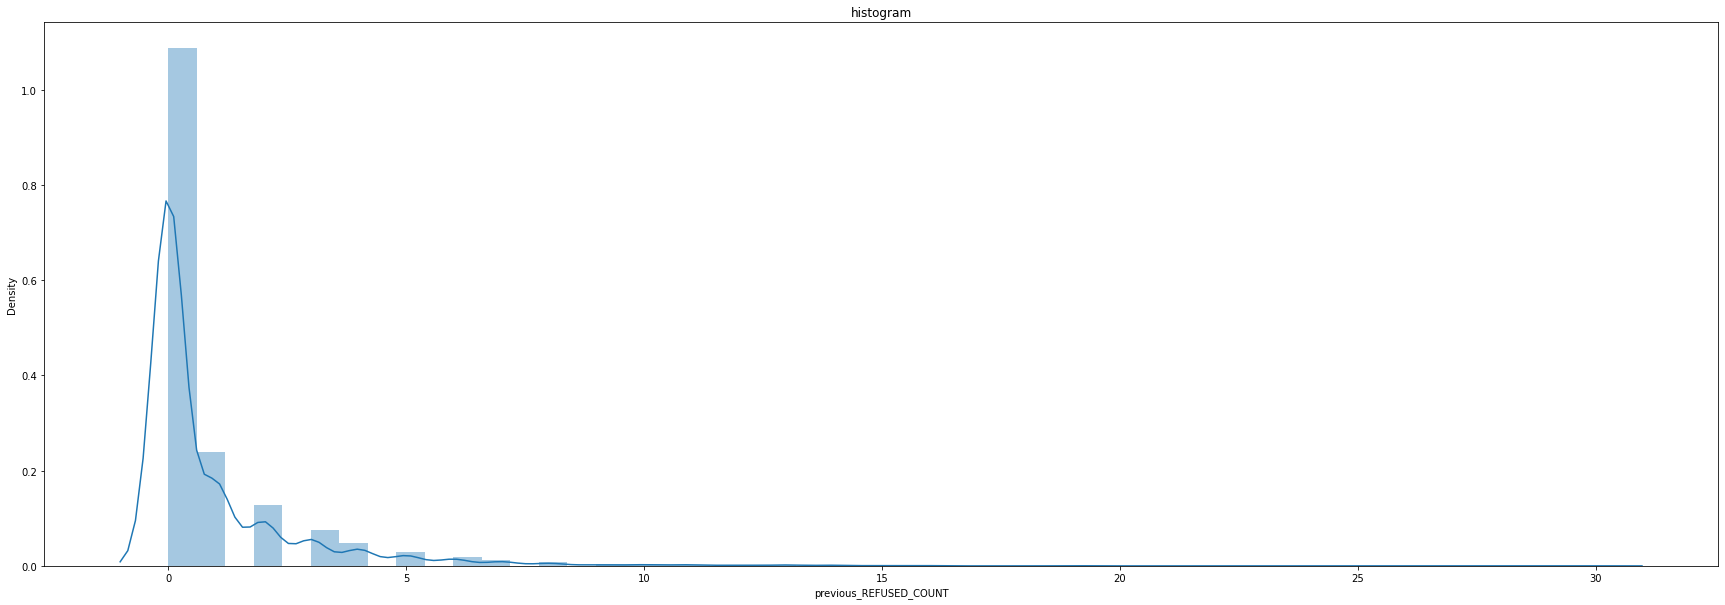

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['previous_REFUSED_COUNT'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

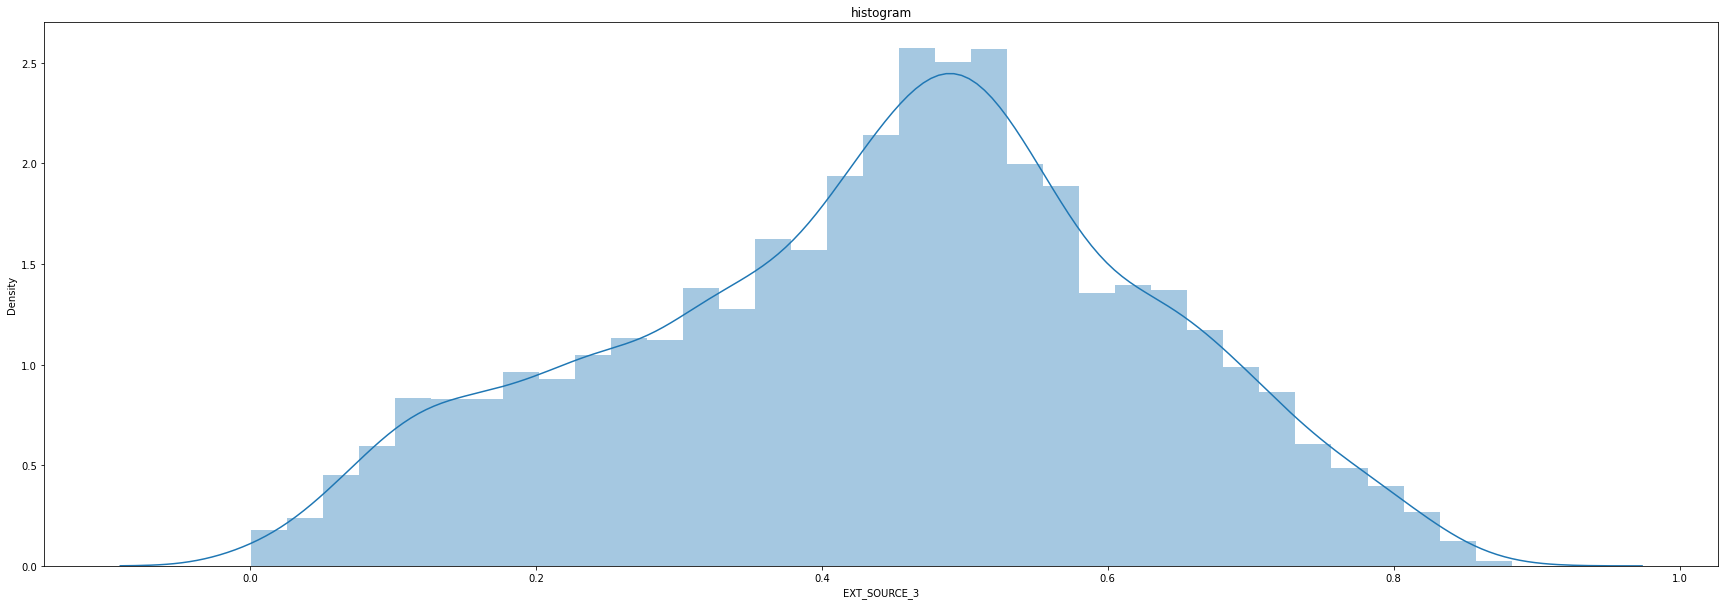

In [ ]:
plt.figure(figsize=(30,10))
sns.distplot(analysis_data['EXT_SOURCE_3'])
plt.title('histogram')
plt.ticklabel_format(style='plain')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

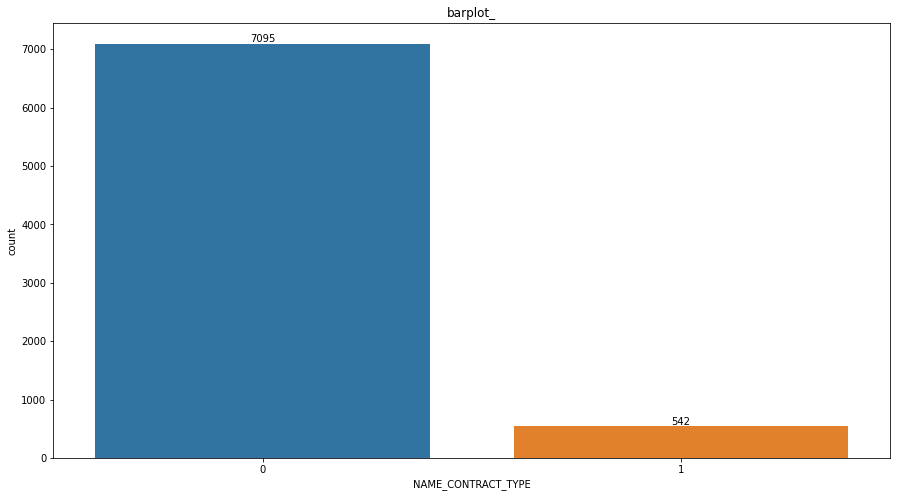

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='NAME_CONTRACT_TYPE', data=analysis_data)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2, height + 30, height, ha = 'center', size = 10)
plt.title('barplot_')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

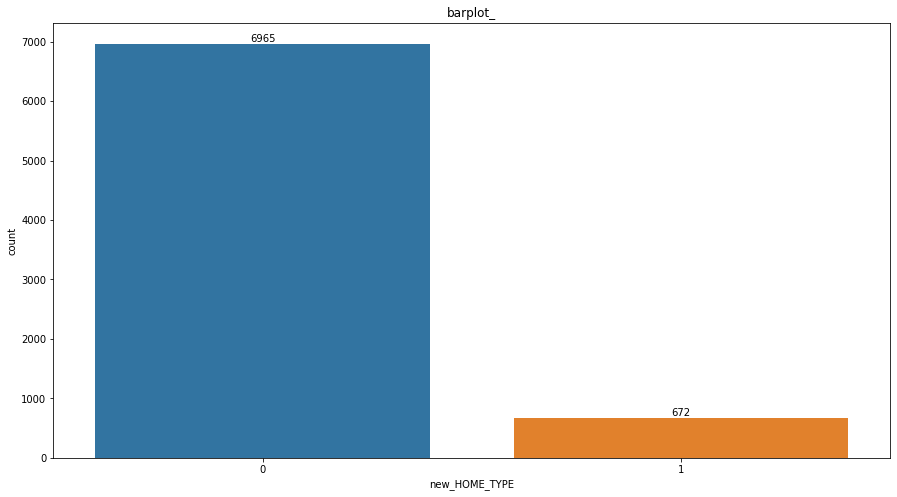

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='new_HOME_TYPE', data=analysis_data)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2, height + 30, height, ha = 'center', size = 10)
plt.title('barplot_')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

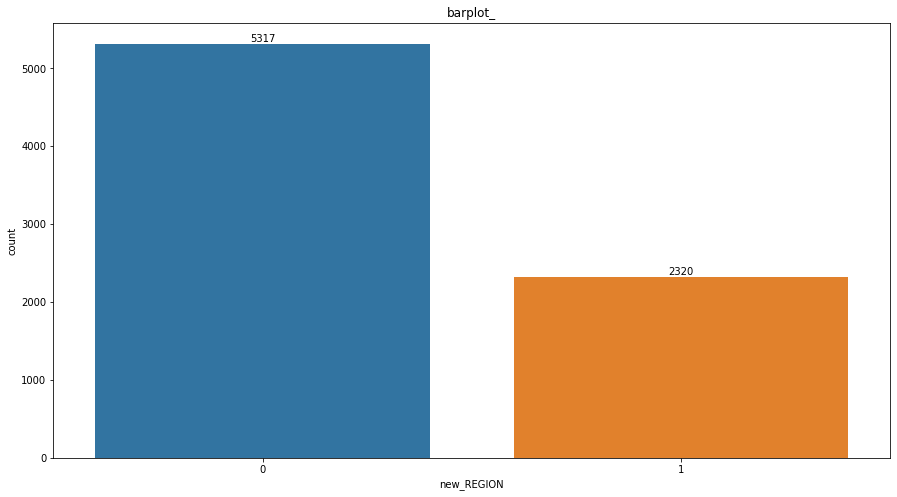

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='new_REGION', data=analysis_data)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width() / 2, height + 30, height, ha = 'center', size = 10)
plt.title('barplot_')
plt.show